In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Классификация объявлений о работе на реальные и мошеннические

Датасет содержит описание множества вакансий о работе. Среди вакансий могут быть как настоящие посты, так и мошеннические. Требуется определять по описания является ли вакансия настоящей или мошеннической.

In [2]:
data_raw = pd.read_csv("fake_job_postings.csv")

## Поверхностный обзор

Обзор признаков:
1. `job_id` - Уникальный идентификатор работы
2. `title` - Название объявления о вакансии.
3. `location` - Географическое местоположение объявления о вакансии.
4. `department` - Корпоративный отдел (например, отдел продаж).
5. `salary_range` - Ориентировочный диапазон заработной платы (например, 50 000–60 000 долларов США)
6. `company_profile` - Краткое описание компании.
7. `description` - Подробное описание вакансии.
8. `requirements` - Перечислены требования к вакансии.
9. `benefits` - Работодатель предлагает рядовым военнослужащим льготы.
10. `telecommuting` - Удаленная работа или нет.
11. `has_company_logo` - Присутствует ли логотип компании.
12. `has_questions` - Присутствуют ли контрольные вопросы.
13. `employment_type` - Полная занятость, неполный рабочий день, контракт и т. д.
14. `required_experience` - Руководитель, Начальный уровень, Стажер и т.д.
15. `required_education` - Докторантура, магистр, бакалавр и т.д.
16. `industry` - Автомобилестроение, ИТ, здравоохранение, недвижимость и т. д.
17. `function` - Консалтинг, инжиниринг, исследования, продажи и т. д.
18. `fraudulent` - Мошенническое ли объявление (целевая переменная).

In [3]:
data_raw.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Объём данных: $N = 17880$

Число признаков: $d = 18$

Количество классов: $K = 2$

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

Можно заметить, что среди нескольких признаков есть пропуски, причём некоторые в значительном количестве. Первый признак `job_id` является уникальным индетификатором вакансии на площадке, поэтому целесообразно будет сразу убрать его, так как он не принесёт пользы в решении задачи.  

In [5]:
data = data_raw.drop(columns=["job_id"])

## Обработка признаков

### Признак `location`

In [6]:
data.location.unique()

array(['US, NY, New York', 'NZ, , Auckland', 'US, IA, Wever', ...,
       'US, CA, los Angeles', 'CA, , Ottawa', 'GB, WSX, Chichester'],
      dtype=object)

In [7]:
data.location.isna().sum()

346

Локация представляет из себя набор: страна, штат (область), город. Кажется целесообразным разделить это на три отдельных признака. Они будут категориальными. Также присутствуют пропущенные значения как в целом, так и отдельно. Для них будем указывать, что информация не предоставлена. 

In [8]:
location_columns = ["country", "state", "city"]

data[location_columns] = data["location"].str.split(",", n=2, expand=True)

for col in location_columns:
    data[col] = data[col].fillna("Unspecified")
    data[col] = data[col].replace(" ", "Unspecified")
    data[col] = data[col].str.strip()
    data[col] = data[col].str.lower()

data = data.drop(columns=["location"])

data[location_columns] = data[location_columns].astype("category")

Получили следующее:

In [9]:
data.country.unique()

['us', 'nz', 'de', 'gb', 'au', ..., 'ni', 'lk', 'jm', 'kz', 'kh']
Length: 91
Categories (91, object): ['ae', 'al', 'am', 'ar', ..., 'vi', 'vn', 'za', 'zm']

In [10]:
data.state.unique()

['ny', 'unspecified', 'ia', 'dc', 'fl', ..., 'der', 'iow', 'dud', 'sn', 'nle']
Length: 325
Categories (325, object): ['00', '01', '02', '03', ..., 'wy', 'yor', 'zet', 'zh']

In [11]:
data.city.unique()

['new york', 'auckland', 'wever', 'washington', 'fort worth', ..., 'sacremento', 'meridian', 'slidell', 'silicon valley/san jose - santa clara', 'berkeley heights']
Length: 2082
Categories (2082, object): ['', '02139', '04102', '10010', ..., 'αthens', 'αθήνα', 'ελληνικο', '마포구 동교동']

### Бинарные признаки

Бинарные признаки не содержат пропущенных значений и уже представлены числами, убедимся в этом

In [12]:
binary_columns = ["telecommuting", "has_company_logo", "has_questions"]

data[binary_columns] = data[binary_columns].astype("category")

In [13]:
data[binary_columns].isna().sum()

telecommuting       0
has_company_logo    0
has_questions       0
dtype: int64

In [14]:
for col in binary_columns:
    print(col.upper())
    print(data[col].unique(), "\n")

TELECOMMUTING
[0, 1]
Categories (2, int64): [0, 1] 

HAS_COMPANY_LOGO
[1, 0]
Categories (2, int64): [0, 1] 

HAS_QUESTIONS
[0, 1]
Categories (2, int64): [0, 1] 



### Остальные категориальные признаки

Заполним пропущенные значения специальной категорией `Unspecified`, а также приведём строки к общему виду

In [15]:
other_columns = [
    "department",
    "salary_range",
    "employment_type",
    "required_experience",
    "required_education",
    "industry",
    "function",
]

data[other_columns] = data[other_columns].fillna("Unspecified")
data[other_columns] = data[other_columns].replace(" ", "Unspecified")

for col in other_columns:
    data[col] = data[col].str.strip()
    data[col] = data[col].str.lower()

data[other_columns] = data[other_columns].astype("category")

Посмотрим какие уникальные значения получились и сколько их

In [16]:
for col in other_columns:
    print(col.upper())
    print(data[col].unique(), "\n")

DEPARTMENT
['marketing', 'success', 'unspecified', 'sales', 'androidpit', ..., 'hotel jobs', 'data entry, clerical admin, administrative as..., 'user experience design', 'admin - clerical', 'administrative dept']
Length: 1224
Categories (1224, object): ['(consultant)', '.net', '.net development', '0', ..., 'youth health clinic', 'área comercial', 'εμπορικο', 'πληροφορικη'] 

SALARY_RANGE
['unspecified', '20000-28000', '100000-120000', '120000-150000', '50000-65000', ..., '21-31', '48000-65000', '53000-67000', '22-61000', '3700-3800']
Length: 875
Categories (875, object): ['0-0', '0-1', '0-1000', '0-100000', ..., 'jun-18', 'oct-15', 'oct-20', 'unspecified'] 

EMPLOYMENT_TYPE
['other', 'full-time', 'unspecified', 'part-time', 'contract', 'temporary']
Categories (6, object): ['contract', 'full-time', 'other', 'part-time', 'temporary', 'unspecified'] 

REQUIRED_EXPERIENCE
['internship', 'not applicable', 'unspecified', 'mid-senior level', 'associate', 'entry level', 'executive', 'director'

Запомним какие колонки представляют категориальные признаки (пригодится далее)

In [17]:
category_columns = data.select_dtypes(include="category").columns
print(category_columns)

Index(['department', 'salary_range', 'telecommuting', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'country', 'state',
       'city'],
      dtype='object')


## Текстовые признаки

In [18]:
text_columns = data.select_dtypes(include="object").columns
print(text_columns)

Index(['title', 'company_profile', 'description', 'requirements', 'benefits'], dtype='object')


С текстовыми признаками будем справляться с помощью метода векторизации. Для этого вначале объединим все текстовые колонки в одну общую и очистим текст.

In [19]:
data[text_columns] = data[text_columns].fillna("")
data["combined_text"] = data[text_columns].agg(" ".join, axis=1)

In [20]:
import re


def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text


data["combined_text"] = data["combined_text"].apply(clean_text)

После разделения выборки проведём саму векторизацию

## Визуализация и характеристики данных

Так как данный датасет не содержит явных количественных признаков, то вычисление характеристик (среднее, разброс, корреляционная матрица и т.д.) не имеет смысла. Для категориальных признаков уникальные значения показаны в предыдущих пунктах. Но можно всякое красиво визуализировать.

Например, посмотрим есть ли несбалансированность классов

<Axes: xlabel='fraudulent', ylabel='count'>

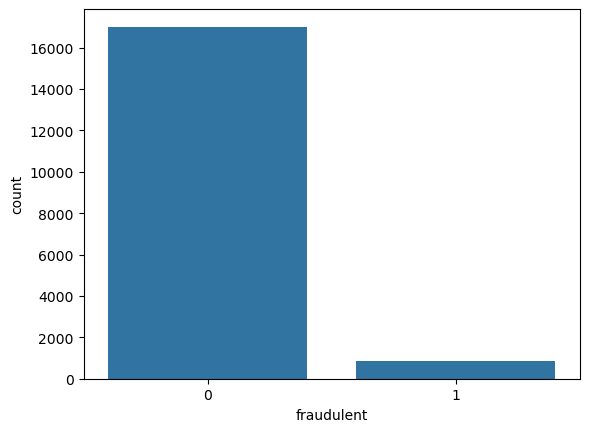

In [21]:
sns.countplot(x="fraudulent", data=data)

Видно, что несбаланнсированность сильная. Сначала посмотрим, что будет, если ничего с этим не делать. Далее попробуем с этим побороться.

Продемонстрируем чаще всего встречающиеся слова в описании работы для трёх случаев:
- общий, 
- для реальных вакансий,
- для мошеннических вакансий.

(-0.5, 799.5, 799.5, -0.5)

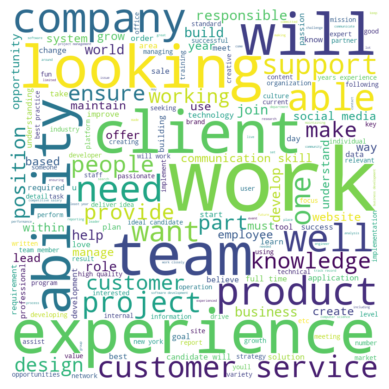

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(width=800, height=800, background_color="white").generate(
    " ".join(data["combined_text"])
)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

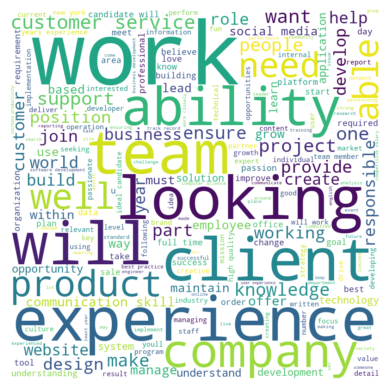

In [ ]:
wc = WordCloud(width=800, height=800, background_color="white").generate(
    " ".join(data[data["fraudulent"] == 0]["combined_text"])
)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

(-0.5, 799.5, 799.5, -0.5)

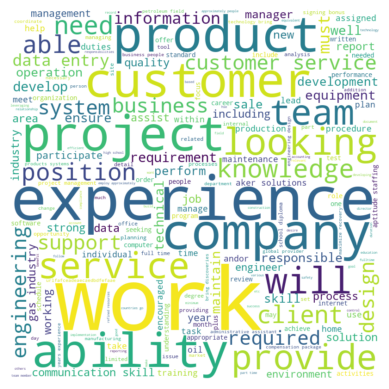

In [ ]:
wc = WordCloud(width=800, height=800, background_color="white").generate(
    " ".join(data[data["fraudulent"] == 1]["combined_text"])
)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

## Разделение на тренировочную и тестовую выборки

In [25]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["fraudulent"])
y = data["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Преобразование признаков

Векторизация текстовых признаков даст нам разреженную матрицу, поэтому можно закодировать категориальные признаки с помощью `OneHotEncoder`.

In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore")
X_train_category = encoder.fit_transform(X_train[category_columns])
X_test_category = encoder.transform(X_test[category_columns])

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_text = vectorizer.fit_transform(X_train["combined_text"])
X_test_text = vectorizer.transform(X_test["combined_text"])

In [28]:
from scipy.sparse import hstack

X_train = hstack([X_train_category, X_train_text])
X_test = hstack([X_test_category, X_test_text])

Векторизованные текстовые признаки имеют значения в диапозоне от 0 до 1. Закодированные категориальные признаки имеют значения 0 или 1. Поэтому нормализация не обязательна.  

## Обучение моделей без балансировки классов

Попробуем обучить несколько моделей без балансировки классов

1. **Логистическая регрессия (Logistic Regression)**:
    - Логистическая регрессия хорошо подходит для разреженных матриц, так как она может эффективно работать с большим количеством признаков, многие из которых могут быть нулевыми.

2. **K-ближайших соседей (K-Nearest Neighbors)**:
    - K-ближайших соседей может быть менее эффективен для разреженных матриц, так как вычислительная сложность возрастает с увеличением числа признаков.

3. **Случайный лес (Random Forest)**:
    - Случайный лес может эффективно работать с разреженными матрицами, так как он использует ансамблевый подход, что позволяет ему справляться с большим количеством признаков.

4. **Метод опорных векторов (Support Vector Machine)**:
    - Метод опорных векторов хорошо подходит для разреженных матриц, так как он может эффективно работать с высокоразмерными данными и использовать различные функции ядра для обработки сложных зависимостей.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


models = {
    "Logistic Regression": {
        "model": LogisticRegression(n_jobs=-1),
        "pred": None,
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(n_jobs=-1),
        "pred": None,
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_jobs=-1),
        "pred": None,
    },
    "SVM": {
        "model": SVC(),
        "pred": None,
    },
}

for name, model in models.items():
    model["model"].fit(X_train, y_train)
    model["pred"] = model["model"].predict(X_test)

Посмотрим какие они дают результаты

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.93      0.61      0.74       181

    accuracy                           0.98      3576
   macro avg       0.96      0.81      0.86      3576
weighted avg       0.98      0.98      0.98      3576
 

K-NEAREST NEIGHBORS
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3395
           1       0.83      0.69      0.76       181

    accuracy                           0.98      3576
   macro avg       0.91      0.84      0.87      3576
weighted avg       0.98      0.98      0.98      3576
 

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.59      0.74       181

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg    

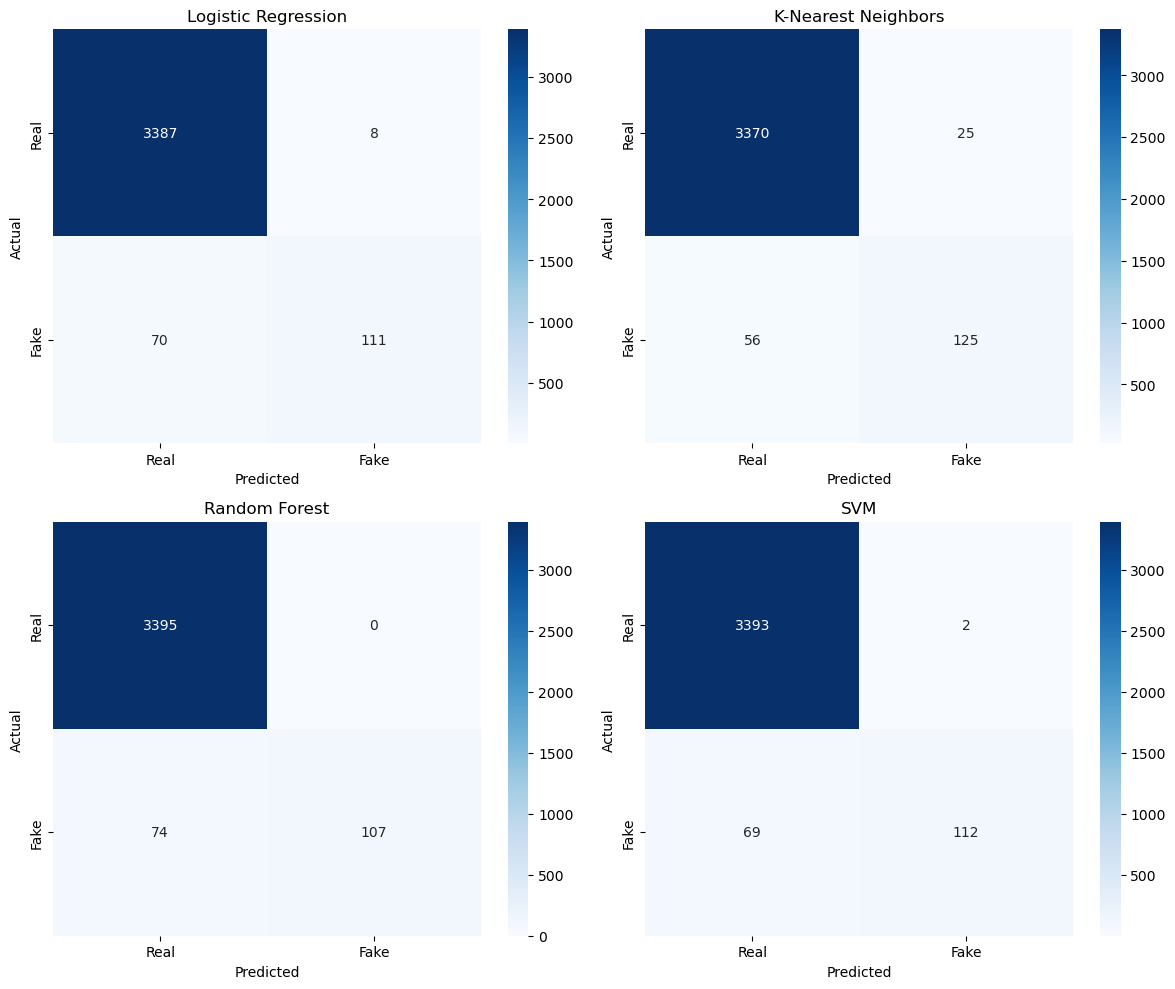

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    print(name.upper())
    print(classification_report(y_test, model["pred"]), "\n")

    cm = confusion_matrix(y_test, model["pred"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        ax=ax,
        xticklabels=["Real", "Fake"],
        yticklabels=["Real", "Fake"],
        cmap="Blues",
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()

У моделей высокая точность определения обоих видов вакансий, но полнота для мошеннических вакансий низкая. Что говорит о том, что многие вакансии действительно являющиеся мошенническими определяются как реальные (ошибка второго рода). Это следствие несбалансированности классов, а именно в недостаточности примеров мошеннических вакансий.  

## Борьба с несбалансированностью классов

Попробуем воспользоваться методом `SMOTE` для борьбы с несбалансированностью классов.

`SMOTE` – это метод оверсэмплинга, который создает синтетические примеры для меньшего класса вместо простого дублирования существующих. Процесс включает следующие шаги:
- Для каждого примера меньшего класса выбираются k ближайших соседей.
- Создаются новые синтетические примеры путем интерполяции между исходным примером и его ближайшими соседями.

In [31]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

Убедимся в успешном результате:

In [32]:
y_train.value_counts()

fraudulent
0    13619
1    13619
Name: count, dtype: int64

## Обучение моделей с сбалансированными классами

In [33]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(n_jobs=-1),
        "pred": None,
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(n_jobs=-1),
        "pred": None,
    },
    "Random Forest": {
        "model": RandomForestClassifier(n_jobs=-1),
        "pred": None,
    },
    "SVM": {
        "model": SVC(),
        "pred": None,
    },
}

for name, model in models.items():
    model["model"].fit(X_train, y_train)
    model["pred"] = model["model"].predict(X_test)

LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3395
           1       0.72      0.88      0.79       181

    accuracy                           0.98      3576
   macro avg       0.86      0.93      0.89      3576
weighted avg       0.98      0.98      0.98      3576
 

K-NEAREST NEIGHBORS
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3395
           1       0.31      0.95      0.47       181

    accuracy                           0.89      3576
   macro avg       0.66      0.92      0.71      3576
weighted avg       0.96      0.89      0.92      3576
 

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       0.98      0.67      0.79       181

    accuracy                           0.98      3576
   macro avg       0.98      0.83      0.89      3576
weighted avg    

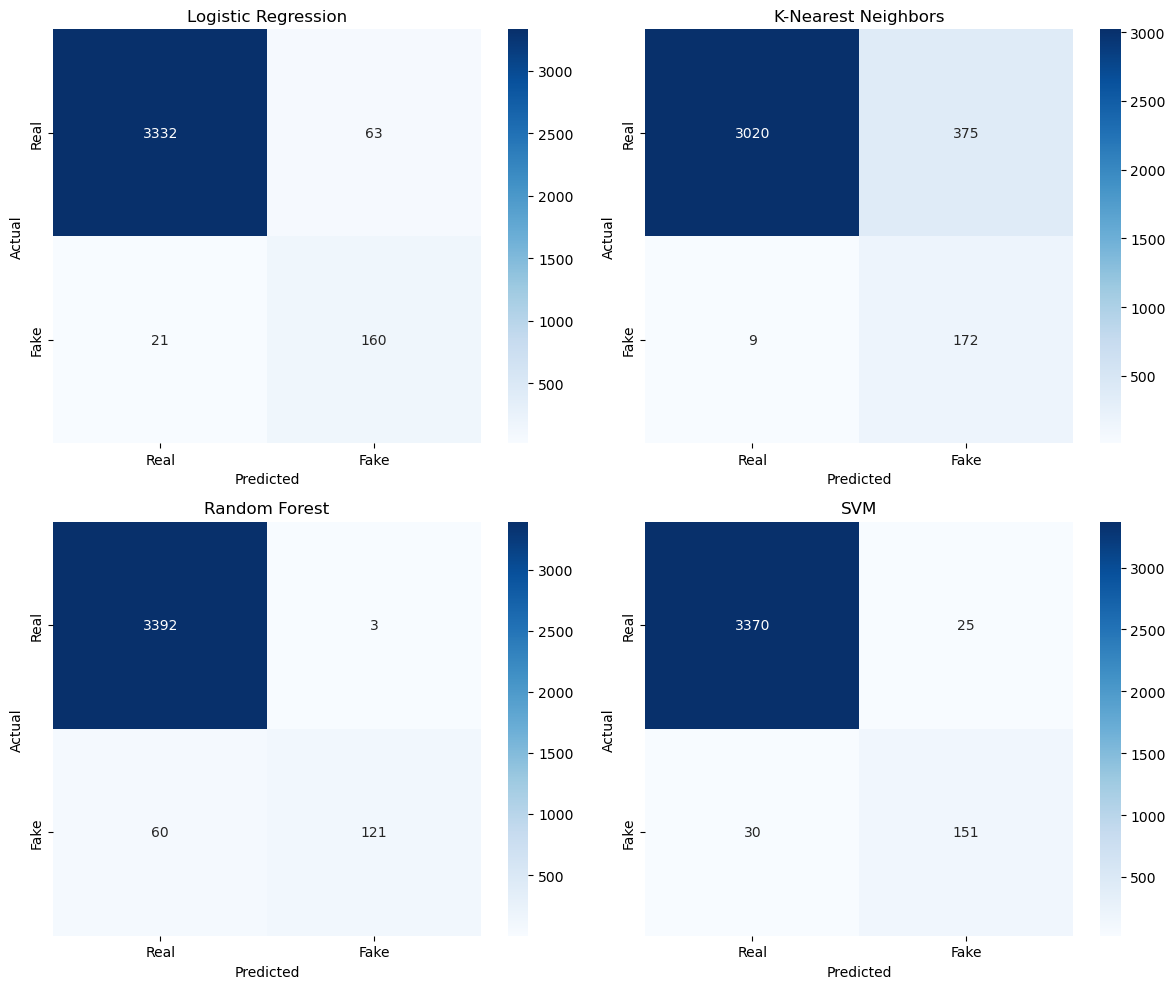

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, model) in zip(axes.ravel(), models.items()):
    print(name.upper())
    print(classification_report(y_test, model["pred"]), "\n")

    cm = confusion_matrix(y_test, model["pred"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        ax=ax,
        xticklabels=["Real", "Fake"],
        yticklabels=["Real", "Fake"],
        cmap="Blues",
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()

После применения метода SMOTE для борьбы с несбалансированностью классов и повторного обучения моделей, результаты значительно улучшились. Теперь модели лучше справляются с определением мошеннических вакансий, что видно по увеличению полноты (recall) для класса мошеннических вакансий. Это означает, что модели стали реже ошибаться, определяя мошеннические вакансии как реальные (уменьшение ошибки второго рода).

Тем не менее, стоит отметить, что увеличение полноты может привести к снижению точности (precision), так как модели могут начать ошибочно определять реальные вакансии как мошеннические (увеличение ошибки первого рода). Поэтому важно найти баланс между точностью и полнотой, чтобы минимизировать обе ошибки.

Визуализация матриц ошибок (confusion matrices) также показывает улучшение в классификации мошеннических вакансий. Теперь модели лучше различают реальные и мошеннические вакансии, что подтверждается увеличением числа правильных предсказаний для обоих классов.

**Logistic Regression**:
- Высокая точность (precision) для реальных вакансий (0.99) и приемлемая для мошеннических (0.72).
- Высокая полнота (recall) для обоих классов, особенно для мошеннических вакансий (0.88).
- Общая точность модели составляет 0.98.
- Модель хорошо сбалансирована между точностью и полнотой, что подтверждается высоким значением f1-score (0.99 для реальных и 0.79 для мошеннических вакансий).

**K-Nearest Neighbors**:
- Очень высокая точность для реальных вакансий (1.00), но низкая для мошеннических (0.31).
- Высокая полнота для мошеннических вакансий (0.95), но низкая для реальных (0.89).
- Общая точность модели составляет 0.89.
- Модель имеет значительное смещение в сторону полноты для мошеннических вакансий, что приводит к большому числу ложных срабатываний.

**Random Forest**:
- Высокая точность для обоих классов (0.98 для реальных и 0.99 для мошеннических).
- Высокая полнота для реальных вакансий (1.00), но ниже для мошеннических (0.65).
- Общая точность модели составляет 0.98.
- Модель показывает отличные результаты для реальных вакансий, но имеет проблемы с полнотой для мошеннических вакансий.

**SVM**:
- Высокая точность для обоих классов (0.99 для реальных и 0.86 для мошеннических).
- Высокая полнота для обоих классов (0.99 для реальных и 0.83 для мошеннических).
- Общая точность модели составляет 0.98.
- Модель хорошо сбалансирована между точностью и полнотой, что подтверждается высоким значением f1-score (0.99 для реальных и 0.85 для мошеннических вакансий).

## Подбор гиперпараметров

Машина опорных векторов, кажется, показала себя наилучшим образом, поэтому попробуем подобрать для неё оптимальные гиперпараметры.

Настройка значения `C` позволяет управлять балансом между недообучением и переобучением. Меньшее значение `C` поощряет большую границу, что может привести к более простой границе решений и лучшему обобщению. Напротив, большее значение `C` стремится правильно классифицировать все обучающие примеры, что может привести к переобучению.

Настройка `gamma` влияет на гибкость границы решений. Более низкое значение `gamma` делает модель более обобщенной, в то время как более высокое значение `gamma` делает модель более чувствительной к обучающим данным, что может захватывать более сложные паттерны, но также увеличивает риск переобучения.

In [35]:
# from sklearn.model_selection import GridSearchCV


# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf','linear']}

# grid_search = GridSearchCV(SVC(), param_grid, n_jobs=-1)

# grid_search.fit(X_train, y_train)

In [36]:
# print("Подобранные лучшие параметры: ", grid_search.best_params_)

Подобранные лучшие параметры:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}. Визуализируем результаты.

In [37]:
tuned_model = SVC(C=10, gamma=0.1)
tuned_model.fit(X_train, y_train)
y_pred = tuned_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3395
           1       0.95      0.80      0.87       181

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



Text(50.722222222222214, 0.5, 'Actual')

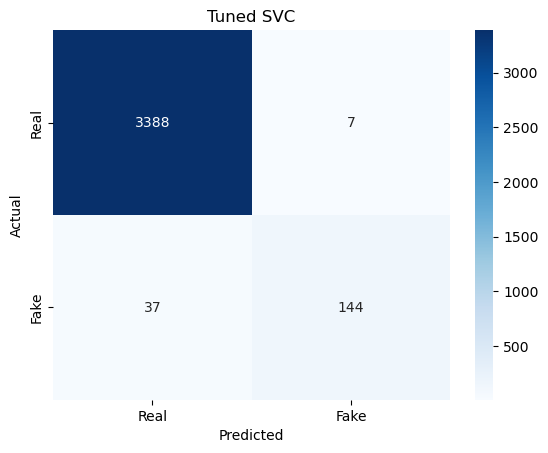

In [38]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
    cmap="Blues",
)
plt.title("Tuned SVC")
plt.xlabel("Predicted")
plt.ylabel("Actual")

1. Подбор оптимальных гиперпараметров позволил улучшить общую производительность модели:
- Повысилась точность определения мошеннических вакансий с 0.86 до 0.95
- Увеличилась общая точность с 0.98 до 0.99

2. Модель стала более сбалансированной:
- Сохранилась высокая точность определения реальных вакансий
- Значительно улучшилась точность определения мошеннических вакансий
- При этом полнота для мошеннических вакансий незначительно снизилась с 0.83 до 0.80

3. Настроенная модель более надежна для практического применения, так как:
- Меньше ложных срабатываний при определении мошеннических вакансий
- Сохраняется высокая способность находить настоящие мошеннические вакансии
- Обеспечивается лучший баланс между точностью и полнотой

По сравнению с другими моделями (логистическая регрессия, случайный лес, k ближайших соседей), настроенный SVM показывает наилучшие результаты для данной задачи классификации.

**Общие выводы:**
- Успешно обработан несбалансированный набор данных с вакансиями
- Применена векторизация TF-IDF для преобразования текста в числовые признаки
- Протестированы различные алгоритмы классификации:
    - Логистическая регрессия
    - Случайный лес
    - K-ближайших соседей (KNN)
    - Машина опорных векторов (SVM)
- SVM с оптимизированными гиперпараметрами показал наилучшие результаты:
    - Общая точность: 0.99
    - Точность определения мошеннических вакансий: 0.95
    - Высокая устойчивость к ложным срабатываниям